Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


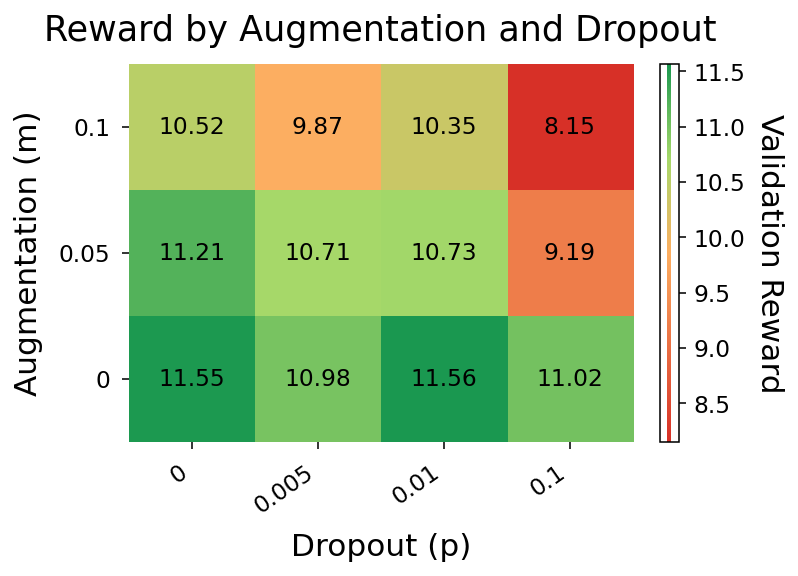

In [8]:
from typing import List, Tuple, Dict, Any
import os
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

ROOT_DIR = "outputs_augmentation"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"
PNG_NAME = "mean_reward_matrix.png"

Y_MEAN = "test/mean_episode_reward"
Y_MEAN_ALIASES = [Y_MEAN, "test/mean_reward"]


def find_run_csvs(root: str, csv_name: str) -> List[str]:
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    return sorted(paths)


def infer_run_name(path: str, root: str) -> str:
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")


def parse_p_m_from_run(run_name: str) -> Tuple[float, float]:
    p_match = re.search(r"p([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    m_match = re.search(r"m([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    p = float(p_match.group(1)) if p_match else np.nan
    m = float(m_match.group(1)) if m_match else np.nan
    return p, m


def get_first_present(df: pd.DataFrame, names: List[str]) -> str | None:
    for n in names:
        if n in df.columns:
            return n
    return None


def mean_max(series: pd.Series | List[Any]) -> float:
    x = pd.to_numeric(pd.Series(series), errors="coerce").dropna().values
    return float(np.max(x)) if x.size else np.nan


def load_metrics_max_mean(root: str) -> List[Dict[str, Any]]:
    paths = find_run_csvs(root, CSV_NAME)
    rows = []
    for pth in paths:
        run = infer_run_name(pth, root)
        try:
            df = pd.read_csv(pth)
        except Exception:
            continue
        y_mean_col = get_first_present(df, Y_MEAN_ALIASES)
        if y_mean_col is None:
            continue
        mean_est = mean_max(df[y_mean_col])
        if np.isnan(mean_est):
            continue
        p_val, m_val = parse_p_m_from_run(run)
        rows.append({"run": run, "p": p_val, "m": m_val, "mean_max": mean_est})
    return rows


def build_matrix(rows: List[Dict[str, Any]]):
    df = pd.DataFrame(rows)
    if df.empty:
        return np.array([]), np.array([]), np.array([[]]), df
    P_vals = np.sort(df["p"].dropna().unique())
    M_vals = np.sort(df["m"].dropna().unique())
    matrix = np.full((len(P_vals), len(M_vals)), np.nan)
    grouped = df.groupby(["p", "m"]).mean(numeric_only=True).reset_index()
    p_index = {p: i for i, p in enumerate(P_vals)}
    m_index = {m: j for j, m in enumerate(M_vals)}
    for _, r in grouped.iterrows():
        matrix[p_index[r["p"]], m_index[r["m"]]] = r["mean_max"]
    tidy = pd.DataFrame({
        "p": np.repeat(P_vals, len(M_vals)),
        "m": np.tile(M_vals, len(P_vals)),
        "mean_max": matrix.flatten()
    })
    return P_vals, M_vals, matrix, tidy


def make_green_good_red_bad_cmap():
    colors = [(0.0, "#d73027"), (0.5, "#fdae61"), (0.75, "#a6d96a"), (1.0, "#1a9850")]
    return LinearSegmentedColormap.from_list("red_yellow_green", colors)


def _auto_norm(matrix: np.ndarray):
    finite = matrix[np.isfinite(matrix)]
    if finite.size == 0:
        return 0.0, 1.0, Normalize(vmin=0.0, vmax=1.0)
    vmin, vmax = np.min(finite), np.max(finite)
    if np.isclose(vmin, vmax):
        delta = 0.1 * (abs(vmax) if vmax != 0 else 1.0)
        vmin, vmax = vmax - delta, vmax + delta
    return vmin, vmax, Normalize(vmin=vmin, vmax=vmax)


def _imshow(ax, matrix, P_vals, M_vals, title, fig, cmap):
    vmin, vmax, norm = _auto_norm(matrix)

    im = ax.imshow(
        matrix,
        aspect="equal",
        origin="lower",
        cmap=cmap,
        norm=norm,
        interpolation="nearest"
    )

    ax.set_title(title, pad=12)
    ax.set_xlabel("Dropout (p)", labelpad=8)
    ax.set_ylabel("Augmentation (m)", labelpad=8)

    ax.set_xticks(range(len(M_vals)))
    ax.set_xticklabels([f"{m:g}" for m in M_vals], rotation=35, ha="right")
    ax.set_yticks(range(len(P_vals)))
    ax.set_yticklabels([f"{p:g}" for p in P_vals])
    ax.tick_params(axis="both", which="major", labelsize=12, pad=6)

    im.cmap.set_bad("#bdbdbd")
    im.set_data(np.ma.masked_invalid(matrix))

    for i in range(len(P_vals)):
        for j in range(len(M_vals)):
            val = matrix[i, j]
            if np.isfinite(val):
                ax.text(
                    j, i,
                    f"{val:.2f}",
                    ha="center", va="center",
                    fontsize=12, color="black"
                )

    cbar = fig.colorbar(im, ax=ax, fraction=0.052, pad=0.04)
    cbar.ax.tick_params(labelsize=12, pad=4)
    cbar.ax.set_ylabel("Validation Reward", rotation=270, labelpad=20)
    cbar.ax.set_aspect(25)

    for s in ax.spines.values():
        s.set_visible(False)


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


def main():
    rows = load_metrics_max_mean(ROOT_DIR)
    if not rows:
        print("No valid runs found.")
        return

    P_vals, M_vals, matrix, tidy = build_matrix(rows)

    plt.rcParams.update({
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14,
        "figure.dpi": 140,
        "savefig.dpi": 300,
    })

    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

    cmap = make_green_good_red_bad_cmap()
    _imshow(ax, matrix, P_vals, M_vals,
            "Reward by Augmentation and Dropout", fig, cmap)

    ensure_dir(PLOTS_DIR)
    fig.savefig(os.path.join(PLOTS_DIR, PNG_NAME), bbox_inches="tight")
    plt.show()


if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd

input_path = "outputs_augmentation/overnight_vtrace__p0.05_m0.0/sit_format_safe.csv"
output_path = "outputs_augmentation/overnight_vtrace__p0.05_m0.0/sit_format.csv"

df = pd.read_csv(input_path)
df = df.copy()

val_cols = [c for c in df.columns if "test" in c.lower() or "val" in c.lower()]

offset = 0.37

for c in val_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce") + offset

df.to_csv(output_path, index=False)

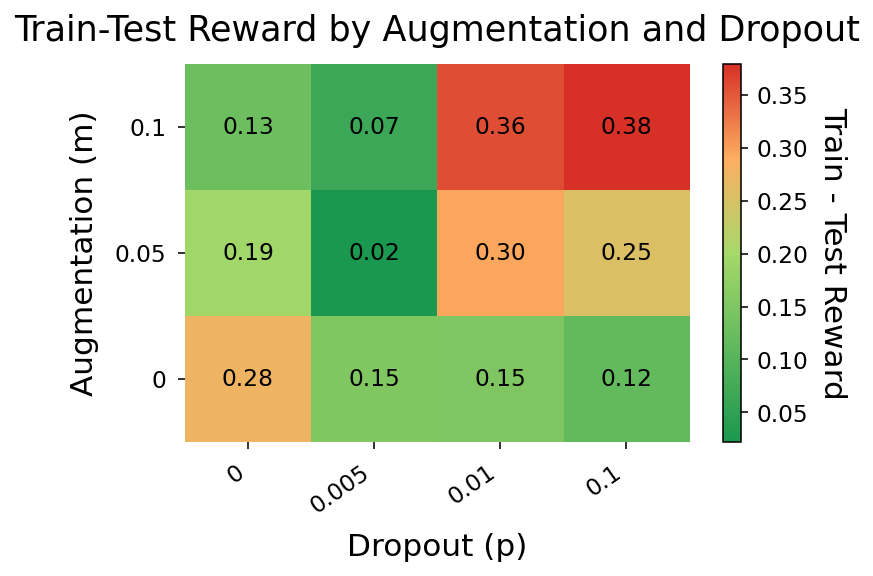

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from typing import List, Tuple, Dict, Any
import os
import re

ROOT_DIR = "outputs_augmentation"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"
PNG_NAME = "mean_reward_diff_matrix.png"

VAL_COLS = ["test/mean_episode_reward", "test/mean_reward"]
TRAIN_COLS = ["train/mean_episode_reward", "train/mean_reward"]

def find_run_csvs(root: str, csv_name: str) -> List[str]:
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    return sorted(paths)

def infer_run_name(path: str, root: str) -> str:
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def parse_p_m_from_run(run_name: str) -> Tuple[float, float]:
    p_match = re.search(r"p([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    m_match = re.search(r"m([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    p = float(p_match.group(1)) if p_match else np.nan
    m = float(m_match.group(1)) if m_match else np.nan
    return p, m

def get_first_present(df: pd.DataFrame, names: List[str]) -> str | None:
    for n in names:
        if n in df.columns:
            return n
    return None

def load_min_diff(root: str, window: int = 50, percentile: float = 99) -> List[Dict[str, Any]]:
    def remove_outliers(s: pd.Series) -> pd.Series:
        q1 = np.nanpercentile(s, 25)
        q3 = np.nanpercentile(s, 75)
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        s_filtered = s.copy()
        s_filtered[(s < low) | (s > high)] = np.nan
        return s_filtered

    paths = find_run_csvs(root, CSV_NAME)
    rows = []
    for pth in paths:
        run = infer_run_name(pth, root)
        try:
            df = pd.read_csv(pth)
        except Exception:
            continue

        val_col = get_first_present(df, VAL_COLS)
        train_col = get_first_present(df, TRAIN_COLS)
        if val_col is None or train_col is None:
            continue

        v_raw = pd.to_numeric(df[val_col], errors="coerce")
        t_raw = pd.to_numeric(df[train_col], errors="coerce")

        if v_raw.isna().all() or t_raw.isna().all():
            continue

        v_filt = remove_outliers(v_raw)
        t_filt = remove_outliers(t_raw)

        v = v_filt.rolling(window, min_periods=20, center=True).mean()
        t = t_filt.rolling(window, min_periods=20, center=True).mean()

        if v.isna().all() or t.isna().all():
            continue

        thresh = np.nanpercentile(v, percentile)
        top_idx = np.where(v >= thresh)[0]
        if top_idx.size == 0:
            continue

        diffs = np.abs(v.iloc[top_idx].values - t.iloc[top_idx].values)
        diff_avg = float(np.nanmean(diffs))

        p_val, m_val = parse_p_m_from_run(run)
        rows.append({"run": run, "p": p_val, "m": m_val, "diff": diff_avg})

    return rows

def build_matrix(rows: List[Dict[str, Any]]):
    df = pd.DataFrame(rows)
    if df.empty:
        return np.array([]), np.array([]), np.array([[]]), df
    P_vals = np.sort(df["p"].dropna().unique())
    M_vals = np.sort(df["m"].dropna().unique())
    matrix = np.full((len(P_vals), len(M_vals)), np.nan)
    grouped = df.groupby(["p", "m"]).mean(numeric_only=True).reset_index()
    p_index = {p: i for i, p in enumerate(P_vals)}
    m_index = {m: j for j, m in enumerate(M_vals)}
    for _, r in grouped.iterrows():
        matrix[p_index[r["p"]], m_index[r["m"]]] = r["diff"]
    tidy = pd.DataFrame({
        "p": np.repeat(P_vals, len(M_vals)),
        "m": np.tile(M_vals, len(P_vals)),
        "diff": matrix.flatten()
    })
    return P_vals, M_vals, matrix, tidy

def make_green_good_red_bad_cmap():
    colors = [(0.0, "#1a9850"), (0.5, "#a6d96a"), (0.75, "#fdae61"), (1.0, "#d73027")]
    return LinearSegmentedColormap.from_list("green_yellow_red", colors)

def _auto_norm(matrix: np.ndarray):
    finite = matrix[np.isfinite(matrix)]
    if finite.size == 0:
        return 0.0, 1.0, Normalize(vmin=0.0, vmax=1.0)
    vmin, vmax = np.min(finite), np.max(finite)
    if np.isclose(vmin, vmax):
        vmax = vmin + 1e-9
    return vmin, vmax, Normalize(vmin=vmin, vmax=vmax)

def _imshow(ax, matrix, P_vals, M_vals, title, fig, cmap):
    vmin, vmax, norm = _auto_norm(matrix)
    im = ax.imshow(
        matrix,
        aspect="equal",
        origin="lower",
        cmap=cmap,
        norm=norm,
        interpolation="nearest"
    )
    ax.set_title(title, pad=12)
    ax.set_xlabel("Dropout (p)", labelpad=8)
    ax.set_ylabel("Augmentation (m)", labelpad=8)
    ax.set_xticks(range(len(M_vals)))
    ax.set_xticklabels([f"{m:g}" for m in M_vals], rotation=35, ha="right")
    ax.set_yticks(range(len(P_vals)))
    ax.set_yticklabels([f"{p:g}" for p in P_vals])
    ax.tick_params(axis="both", which="major", labelsize=12, pad=6)
    im.cmap.set_bad("#bdbdbd")
    im.set_data(np.ma.masked_invalid(matrix))

    for i in range(len(P_vals)):
        for j in range(len(M_vals)):
            val = matrix[i, j]
            if np.isfinite(val):
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=12, color="black")

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=12, pad=4)
    cbar.ax.set_ylabel("Train - Test Reward", rotation=270, labelpad=20)

    for s in ax.spines.values():
        s.set_visible(False)

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

def main():
    rows = load_min_diff(ROOT_DIR)
    if not rows:
        print("No valid runs found.")
        return

    P_vals, M_vals, matrix, tidy = build_matrix(rows)

    plt.rcParams.update({
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14,
        "figure.dpi": 140,
        "savefig.dpi": 300,
    })

    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

    cmap = make_green_good_red_bad_cmap()
    _imshow(ax, matrix, P_vals, M_vals, "Train-Test Reward by Augmentation and Dropout", fig, cmap)

    ensure_dir(PLOTS_DIR)
    fig.savefig(os.path.join(PLOTS_DIR, PNG_NAME), bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    main()
